# Aligning
``align`` is a module that can be used to align two different datasets. In particular, all three currently existing classes, namely ``SignFlips``, regular ``OrthogonalProcrustes``, and ``SeedlessProcrustes`` are aimed at correcting an orthogonal transformation of the data, the exact form of which is unknwon. The motivation for this are orthogonal non-identifiabilities, which are common when dealing with various embedding methods, whether in statistical graphs or other domains.

Recall that an orthogonal matrix is any matrix $Q$ such that $Q^T Q = Q Q^T = I$. For all alignment methods, the main idea is to infer an orthogonal matrix $Q$ from the input data sets $X$ and $Y$, and subsequently use $Q$ in order to align $X$ to $Y$, by transforming $X$ as $\hat{X} = X Q$. The major differences among classes in ``align`` come from the settings in which which they are applicable, as well as additional assumptions made on the matrix $Q$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graspologic.plot import heatmap
from scipy.stats import special_ortho_group, ortho_group

%matplotlib inline

## Simple rotation example

First, let's build two simple datasets $X$ and $Y$, with all entries of $X$ coming from the $Uniform(0, 1)$ distribution, and $Y$ is a $Y$ copy of $X$, and subsequently rotated around the origin, using the randomly generated matrix $Q$, displayed below:

In [2]:
np.random.seed(314)
X = np.random.uniform(0, 1, (15, 2))
Q = special_ortho_group.rvs(2)
Y = X @ Q

array([[-0.94924938, -0.31452442],
       [ 0.31452442, -0.94924938]])

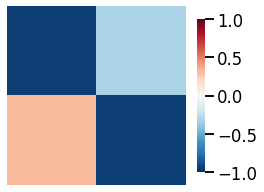

In [3]:
heatmap(Q, figsize=(4,4), vmin=-1, vmax=1)
Q

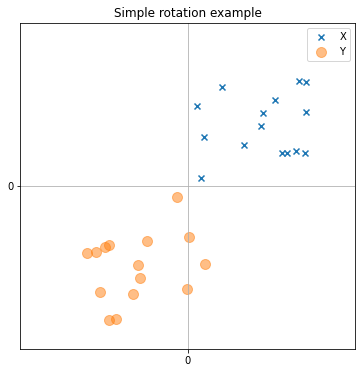

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("Simple rotation example")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1], label="Y", s=100, alpha=0.5)
ax.set(xlim=(-1.3, 1.3), ylim=(-1.3, 1.3))
ax.set_xticks([0])
ax.set_yticks([0])
ax.legend()
ax.grid();

### SignFlips

``SignFlips`` assumes that $Q$ is not only orthogonal, but also diagonal, which constraints to matrices with $\pm 1$ along the diagonal and $0$ everywhere else. In essence, it flips the dataset along some axes such that the two datasets end up in the orthant (generalized quadrant). Which quadrant the dataset is "located" in is defined by some criterion, which is the dimension-wise medians by default. If the dataset needs to flip along some dimension, the corresponding entry in $Q$ will be $-1$, and $1$ otherwise.

In [5]:
from graspologic.align import SignFlips
aligner_SF = SignFlips() 
X_prime_SF = aligner_SF.fit_transform(X, Y)

Since $X$ is entirely in the first quadrant, its dimension-wise medians in both dimensions are greater than $0$. Meanwhile $Y$ is predominantly in the third quadrant, so its dimension-wise medians are all smaller than $0$. Thus $X$ needs to be flipped both along the x-axis and y-axis in order for two datasets to arive to the same dimensions. So, the $Q_{SF}$ that the algorithm finds is

array([[-1,  0],
       [ 0, -1]])

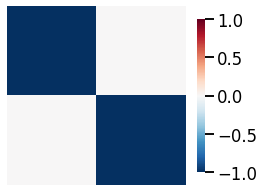

In [6]:
heatmap(aligner_SF.Q_, figsize= (4,4), vmin=-1, vmax=1)
aligner_SF.Q_

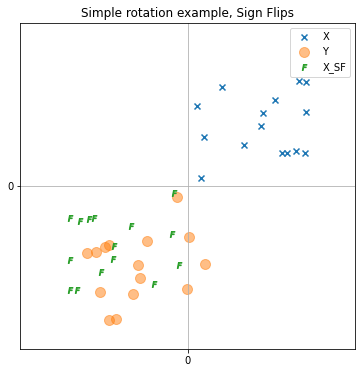

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("Simple rotation example, Sign Flips")
ax.scatter(X[:,0], X[:,1],
           label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1],
           label="Y", s=100, alpha=0.5)
ax.scatter(X_prime_SF[:,0],
           X_prime_SF[:,1],
           label="X_SF", 
           marker='$F$')
ax.set(xlim=(-1.30, 1.30), ylim=(-1.30, 1.30))
ax.set_xticks([0])
ax.set_yticks([0])
ax.legend()
ax.grid();

``SignFlips`` correctly  brings $X$ to the third dimension, yet the alignment is imperfect, as it is a heuristic-based method. Note that it does not assume that there is any sort of matching between the entries of $X$ and $Y$. Indeed, the two datasets need not even be of the same size.

This class can also be used to bring the dataset to the first orthant, if one provides the identity matrix as the second dataset.

### OrthogonalProcrustes

``OrthogonalProcrustes`` obtains $Q_{OP}$ by solving the classic orthogonal procrustes problem. 

[Orthogonal Procrustes problem](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem) is a matrix approximation problem in linear algebra, as one is asked to find a orthogonal matrix $Q$, which could most closely maps the given matrix $X$ to another given matrix $Y$. Formally it seeks to finds a matrix $Q_{OP}$ such that $|| X Q_{OP} - Y ||_F$ is minimized. \\

Since, this formulation strongly relies on the correspondence between the rows of the given matrices, this class can only be applied when the entery datasets $X$ and $Y$ have the equal shape ($n$, $d$), and the $i$th entry in $X$ is assumed to be the same value as vertex $i$th entry of $Y$, up to some noise. In graph setting, this means that the latent positions of the two graphs are equivalent.

Orthogonal Procrustes has a widely known closed form solution. Indeed, this class simply wraps  *[scipy.linal.orthogonal_procrustes()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.orthogonal_procrustes.html)*. 

In [8]:
from graspologic.align import OrthogonalProcrustes
aligner_OP = OrthogonalProcrustes() 
X_prime_OP = aligner_OP.fit_transform(X, Y)

Note that that $Q_{OP}$ is a generic orthogonal matrix, not a diagonal one.

array([[-0.94924938, -0.31452442],
       [ 0.31452442, -0.94924938]])

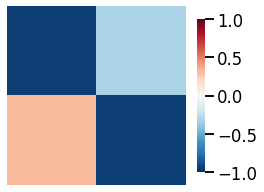

In [9]:
heatmap(aligner_OP.Q_, figsize= (4, 4), vmin=-1, vmax=1)
aligner_OP.Q_

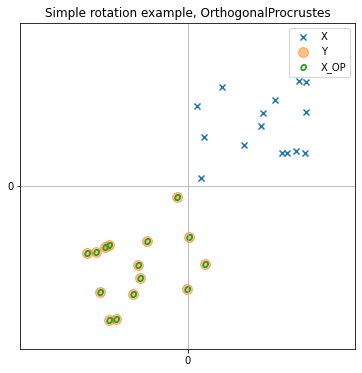

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("Simple rotation example, OrthogonalProcrustes")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1], label="Y", s=100, alpha=0.5)
ax.scatter(X_prime_OP[:,0],
           X_prime_OP[:,1],
           label="X_OP", 
           marker='$O$')
ax.set(xlim=(-1.30, 1.30), ylim=(-1.30, 1.30))
ax.set_xticks([0])
ax.set_yticks([0])
ax.legend()
ax.grid();

As expected, ``OrthogonalProcrustes`` obtains an exact solution when $X$ is a rotated copy of $Y$.

### SeedlessProcrustes

Seedless Procrustes is an algorithm that extends regular Procrustes to a case when there is no known correspondence between the entries. In fact, it can be used even when the number of entries between the two datasest is different.

Formally, if $X$ has $n$ entries, and $Y$ has $m$ entries, it tries to solve for an orthogonal matrix $Q_{SP}$, and an $n \times m$ matrix $P$, with a special condition that rows sum to $1/m$, and columns sum to $1/n$, such that the quantity $|| X Q_{SP} - P Y ||_F$ is minimized.

Unlike the regular procrustes, this does not have a known closed form solution. ``SeedlessProcrustes`` tries to solve this optimization problem via to an iterative algorithm that alternates optimal transport and regular procrustes. See the Notes section of the ``SeedlessProcrustes`` references for more details on this algorithm.

In [11]:
from graspologic.align import SeedlessProcrustes
aligner_SP = SeedlessProcrustes() 
X_prime_SP = aligner_SP.fit_transform(X, Y)

array([[-0.94472887, -0.32785266],
       [ 0.32785266, -0.94472887]])

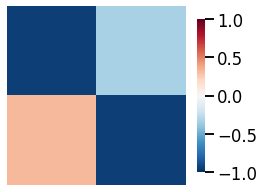

In [12]:
heatmap(aligner_SP.Q_, figsize=(4,4), vmin=-1, vmax=1)
aligner_SP.Q_

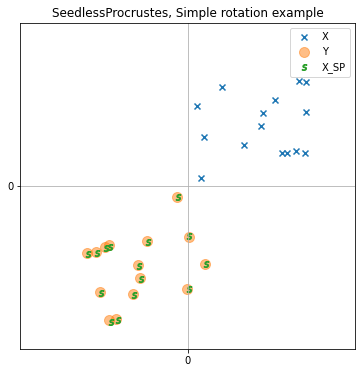

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("SeedlessProcrustes, Simple rotation example")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1], label="Y", s=100, alpha=0.5)
ax.scatter(X_prime_SP[:,0],
           X_prime_SP[:,1],
           label="X_SP", 
           marker='$S$')
ax.set(xlim=(-1.30, 1.30), ylim=(-1.30, 1.30))
ax.set_xticks([0])
ax.set_yticks([0])
ax.legend()
ax.grid();

### Comparison between SignFlips, OrthogonalProcrustes, SeedlessProcrustes

The outcomes of three classes in simple rotation example together are plotted on the same figure in order to allow for a simpler comparison.

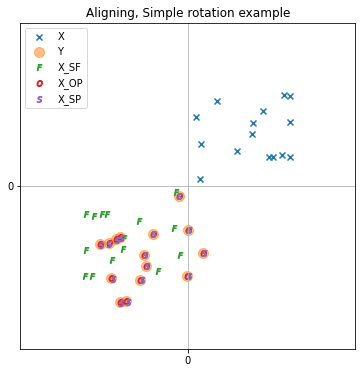

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("Aligning, Simple rotation example")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1], label="Y", s=100, alpha=0.5)
ax.scatter(X_prime_SF[:,0],
           X_prime_SF[:,1], 
           label="X_SF",
           marker='$F$')
ax.scatter(X_prime_OP[:,0],
           X_prime_OP[:,1], 
           label="X_OP", marker='$o$')
ax.scatter(X_prime_SP[:,0],
           X_prime_SP[:,1], 
           label="X_SP", marker='$S$')
ax.set(xlim=(-1.50, 1.50), ylim=(-1.50, 1.50))
ax.set_xticks([0])
ax.set_yticks([0])
ax.legend()
ax.grid();

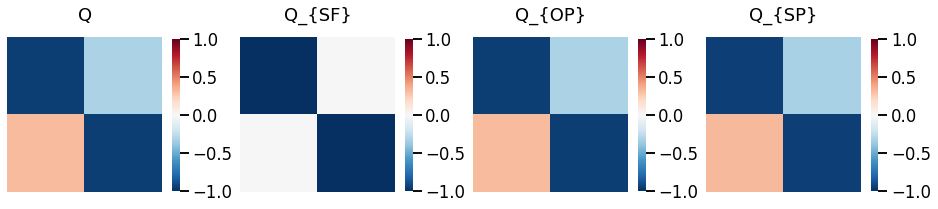

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 4))
heatmap(Q, title='Q', vmin=-1, vmax=1, ax=ax1)
heatmap(aligner_SF.Q_, title='Q_{SF}', vmin=-1, vmax=1, ax=ax2)
heatmap(aligner_OP.Q_, title='Q_{OP}', vmin=-1, vmax=1, ax=ax3)
heatmap(aligner_SP.Q_, title='Q_{SP}', vmin=-1, vmax=1, ax=ax4);

In this simple example, OrthogonalProcrustes and SeedlessProcrustes align $X$ to $Y$ extremply well in terms of the Frobenius norm, whereas Sign Flips can only do so well as to bring them to the same quadrant. In fact, when a dataset is a rotated copy of another - Orthogonal Procrustes aligns it up to a numerical epsilon precision.

In [16]:
norm_SignFlips = np.linalg.norm(X_prime_SF - Y)
norm_Orthogonal = np.linalg.norm(X_prime_OP - Y)
norm_Seedless = np.linalg.norm(X_prime_SP - Y)
print('Simple example')
print('Difference in Frobenious norm after Sign Flips ', norm_SignFlips)
print('Difference in Frobenious norm after Orthogonal Procrustes ', norm_Orthogonal)
print('Difference in Frobenious norm after Seedless Procrustes ', norm_Seedless)

Simple example
Difference in Frobenious norm after Sign Flips  1.047909310874878
Difference in Frobenious norm after Orthogonal Procrustes  5.800542824167306e-16
Difference in Frobenious norm after Seedless Procrustes  0.046291889999320164


## Shuffled Example

Recall that unlike the other two methods, Orthogonal Procrustes heavily relies on a fact that the vertices of the two datasets are matched. Its performance will deteriarete even on this simple example if the vertices are shuffled, as shown in the following figure.

In [17]:
from sklearn.utils import shuffle

In [18]:
X_shuffled = shuffle(X)

In [19]:
aligner_SF_shuffled = SignFlips()
X_prime_SF_shuffled = aligner_SF_shuffled.fit_transform(X_shuffled, Y)
aligner_OP_shuffled = OrthogonalProcrustes()
X_prime_OP_shuffled = aligner_OP_shuffled.fit_transform(X_shuffled, Y)
aligner_SP_shuffled = SeedlessProcrustes()
X_prime_SP_shuffled = aligner_SP_shuffled.fit_transform(X_shuffled, Y)

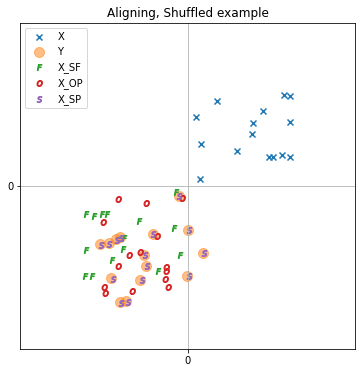

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("Aligning, Shuffled example")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1], label="Y", s=100, alpha=0.5)
ax.scatter(X_prime_SF_shuffled[:,0],
           X_prime_SF_shuffled[:,1], 
            label="X_SF", marker='$F$')
ax.scatter(X_prime_OP_shuffled[:,0],
           X_prime_OP_shuffled[:,1], 
            label="X_OP", marker='$o$')
ax.scatter(X_prime_SP_shuffled[:,0],
           X_prime_SP_shuffled[:,1], 
            label="X_SP", marker='$S$')
ax.set(xlim=(-1.50, 1.50), ylim=(-1.50, 1.50))
ax.set_xticks([0])
ax.set_yticks([0])
ax.legend()
ax.grid();

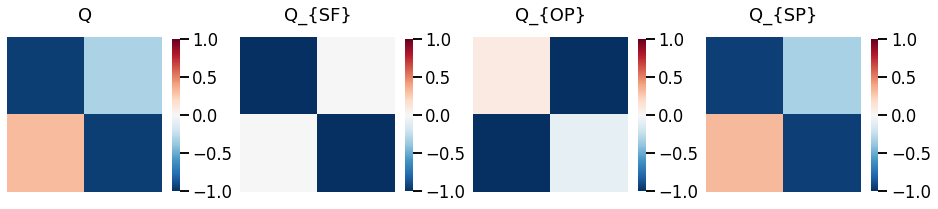

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 4))
heatmap(Q, title='Q', vmin=-1, vmax=1, ax=ax1)
heatmap(aligner_SF_shuffled.Q_, title='Q_{SF}', vmin=-1, vmax=1, ax=ax2)
heatmap(aligner_OP_shuffled.Q_, title='Q_{OP}', vmin=-1, vmax=1, ax=ax3)
heatmap(aligner_SP_shuffled.Q_, title='Q_{SP}', vmin=-1, vmax=1, ax=ax4);

## Unmatched example

As mentioned above, Seedless Procrustes can be applied to two datasets with different number of entries. Consider the following example: $X$ is the same as previous, but the new $Y$ is a *different, larger* dataset, generated from the *same distribution*, and then subsequently rotated.

In [22]:
Y_unmatched = np.random.uniform(0, 1, (30, 2)) @ Q

In [23]:
aligner_SF_unmatched = SignFlips()
X_prime_SF_unmatched = aligner_SF_unmatched.fit_transform(X, Y_unmatched)
aligner_SP_unmatched = SeedlessProcrustes()
X_prime_SP_unmatched = aligner_SP_unmatched.fit_transform(X, Y_unmatched)

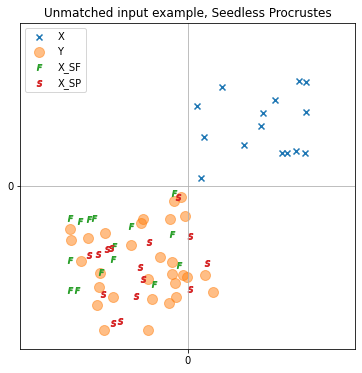

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("Unmatched input example, Seedless Procrustes")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y_unmatched[:,0], Y_unmatched[:,1], label="Y", s=100, alpha=0.5)
ax.scatter(X_prime_SF_unmatched[:,0],
           X_prime_SF_unmatched[:,1],
           label="X_SF", 
           marker='$F$')
ax.scatter(X_prime_SP_unmatched[:,0],
           X_prime_SP_unmatched[:,1],
           label="X_SP", 
           marker='$S$')
ax.set(xlim=(-1.30, 1.30), ylim=(-1.30, 1.30))
ax.set_xticks([0])
ax.set_yticks([0])
ax.legend()
ax.grid();

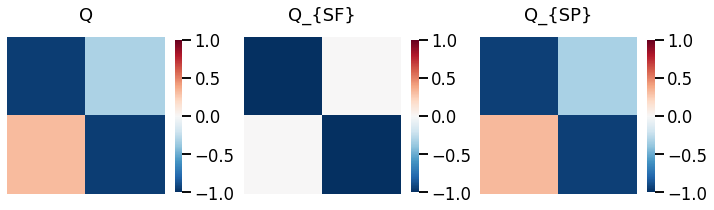

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
heatmap(Q, title='Q', vmin=-1, vmax=1, ax=ax1)
heatmap(aligner_SF_shuffled.Q_, title='Q_{SF}', vmin=-1, vmax=1, ax=ax2)
heatmap(aligner_SP_shuffled.Q_, title='Q_{SP}', vmin=-1, vmax=1, ax=ax3);

In [26]:
print("Mean of the dataset X:      ", np.mean(X, axis=0))
print("Mean of the dataset Y:      ", np.mean(Y, axis=0))
print("Mean of the dataset X_{SP}: ", np.mean(X_prime_SP_unmatched, axis=0))

Mean of the dataset X:       [0.58510607 0.48290266]
Mean of the dataset Y:       [-0.4035269 -0.6424252]
Mean of the dataset X_{SP}:  [-0.38535747 -0.65348582]


Seedless Procrustes is still able to align the distributions, while the Sign Flips method is only a good h. Note that the regular procrustes is simply inapplicable in this context.